<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/4_ArchitecturalBasics/Experiments/MNIST_Exp7_With17kParams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Architectural Basics

Write MNIST code such that:
- 99.4% validation accuracy
- Less than 20k Parameters
- Less than 20 Epochs
- Have used BN, Dropout, a Fully connected layer, have used GAP. 

# Import Libraries

Let's first import all the necessary libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR



# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

## Defining the Model

- Updated the network to have less than 20K parameters
- Added batch norm after every layer except last layer
- Added Transition layer (Max pool followed by 1x1) to reduce the number of channels after every block
- Add GAP layer
- Also added a FC layer
- Added Drop out of 0.1 after every layer except last layer




In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        #Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3,padding=1,bias=False),  # 28x28 output 26x26 RF : 3x3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.1),

            nn.Conv2d(8, 16, 3,padding=1,bias=False), # 28x28 output 28x28 RF : 5x5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            nn.Conv2d(16, 32, 3,bias=False), # 28x28 output 26x26 RF : 7x7
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),
        
        )

        #Transition Block (MaxPool + 1x1)
        self.trans1 = nn.Sequential(

            nn.MaxPool2d(2, 2),  # 26x26 output - 13x13 RF 14x14

            # 1x1 convolution
            nn.Conv2d(32, 8, 1,bias=False), # 13x13 output - 13x13 RF 14x14
            nn.ReLU(),
        )

        #Block 2
        self.conv2 =  nn.Sequential(

            nn.Conv2d(8, 16, 3,bias=False), # 13x13 output - 11x11 RF 16x16
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            nn.Conv2d(16, 32, 3,bias=False),  # 11x11 output - 9x9 RF 18x18
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1), 
        )

        #Transition Block (1x1)
        self.trans2 = nn.Sequential(

            # 1x1 convolution
            nn.Conv2d(32, 8, 1,bias=False), # 11x11 output - 9x9 RF 18x18
            nn.ReLU(),
        )

        #Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 16, 3,bias=False), # 9x9 output - 7x7 RF 20x20
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1), 

            
        )

        #Block 4 and GAP Layer
        self.avg_pool = nn.Sequential(
            nn.Conv2d(16, 16, 3,bias=False), # 7x7 output - 5x5 RF 22x22
            nn.AvgPool2d(3, stride=1, padding=0)
        )

        #Fully Connected Layer
        self.fc = nn.Linear(16*3*3,10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return F.log_softmax(x,dim=1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,152
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
         Dropout2d-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 32, 26, 26]           4,608
             ReLU-10           [-1, 32, 26, 26]               0
      BatchNorm2d-11           [-1, 32, 26, 26]              64
        Dropout2d-12           [-1, 32, 26, 26]               0
        MaxPool2d-13           [-1, 32, 13, 13]               0
           Conv2d-14            [-1, 8,

## The Model

In [ ]:
model.eval()

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout2d(p=0.1, inplace=False)
  )
  (trans1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=Fal

## Model Parameters

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 17,250 trainable parameters


## Load and Prepare Dataset

MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels

We load the PIL images using torchvision.datasets.MNIST, while loading the image we transform he data to tensor and normalize the images with mean and std deviation of MNIST images.

In [ ]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

test = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True, **kwargs)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#Statistics



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)
 - mean: 33.318421449829934
 - std: 78.56748998339798
 - var: 6172.850482291342
torch.Size([128, 1, 28, 28])
torch.Size([128])


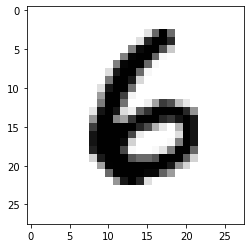

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
#train_data = train.transform(train_data.cpu().numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', train.train_data.cpu().numpy().mean())
print(' - std:', train.train_data.cpu().numpy().std())
print(' - var:', train.train_data.cpu().numpy().var())

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)



plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

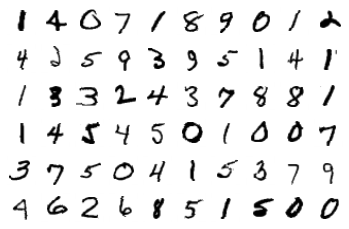

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Training and Testing Loop

In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss=0
    correct = 0
    # processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        #processed += len(data)

        pbar.set_description(desc= f'epoch={epoch} loss={loss.item():.10f} batch_id={batch_idx:05d}')
    #print( f'Epoch {epoch} - \nTrain set : loss={loss.item()} batch_id={batch_idx}')
    train_loss = epoch_loss / len(train_loader)
    train_acc=100.*correct/len(train_loader.dataset)

    return train_loss,train_acc


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc=100. * correct / len(test_loader.dataset)
    return test_loss,test_acc

## Let's write train and test the model

In [ ]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.9)

train_loss_values = []
test_loss_values = []
train_accuracy=[]
test_accuracy=[]

scheduler = StepLR(optimizer, step_size=10, gamma=0.01)

for epoch in range(1, 20):
    train_loss,train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss,test_acc = test(model, device, test_loader)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

    scheduler.step()

  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0595, Accuracy: 9807/10000 (98.07%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0355, Accuracy: 9883/10000 (98.83%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0330, Accuracy: 9896/10000 (98.96%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0304, Accuracy: 9908/10000 (99.08%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0265, Accuracy: 9920/10000 (99.20%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0281, Accuracy: 9918/10000 (99.18%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0244, Accuracy: 9934/10000 (99.34%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0227, Accuracy: 9928/10000 (99.28%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0228, Accuracy: 9930/10000 (99.30%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0228, Accuracy: 9926/10000 (99.26%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0187, Accuracy: 9938/10000 (99.38%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0186, Accuracy: 9937/10000 (99.37%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0184, Accuracy: 9938/10000 (99.38%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0181, Accuracy: 9940/10000 (99.40%)



epoch=19 loss=0.0187097117 batch_id=00468: 100%|██████████| 469/469 [00:16<00:00, 27.75it/s]


Test set: Average loss: 0.0182, Accuracy: 9942/10000 (99.42%)



## Ploting the loss

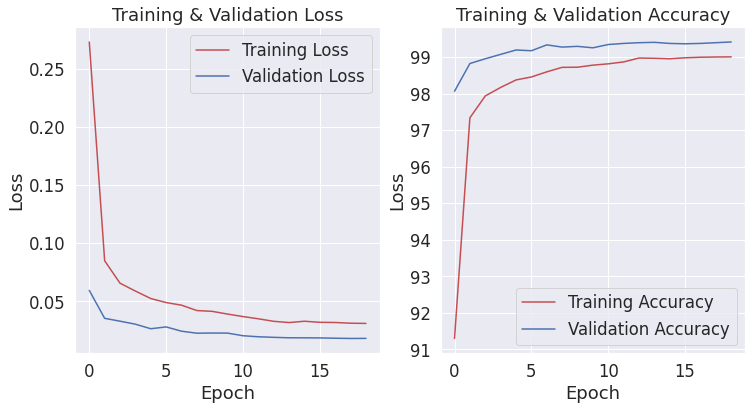

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import numpy as np
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(np.array(train_loss_values), 'r', label="Training Loss")
ax1.plot(np.array(test_loss_values), 'b', label="Validation Loss")

# Label the plot.
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(np.array(train_accuracy), 'r', label="Training Accuracy")
ax2.plot(np.array(test_accuracy), 'b', label="Validation Accuracy")

# Label the plot.
ax2.set_title("Training & Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()

plt.show()

## Final Results

- Model has 17K parametes
- Added batch norm after every layer except last layer
- Added Transition layer (Max pool followed by 1x1) to reduce the number of channels after every block
- Add GAP layer
- Also added a FC layer after GAP
- Used Augmentation like image rotation
- Added Drop out of 0.1 after every layer except last layer
- The model was trained with a learning rate of 0.015 amd momentum of 0.9
- Network was trained for 19 epochs with batch size of 128
- Achieved a test accuracy of 99.42% at 19th epoch
